In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from helper_functions import euclidean_distance
from helper_functions import contrastive_loss
from helper_functions import load_arrays
from helper_functions import plot_training
from helper_functions import load_and_split_data
from helper_functions import plot_confusion_matrix
from helper_functions import get_model_predictions
from helper_functions import plot_roc_curve
from helper_functions import plot_prec_rec_curve

# Load and prepare Data

### Load and create fast input pipeline with tf.data.dataset

In [4]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_10000.npz", "npz_datasets/data_y_10000.npz", split_size=80, batch_size=256)

CPU times: user 11.9 s, sys: 2.81 s, total: 14.7 s
Wall time: 14.7 s


# Baseline Model

In [4]:
img_width = 224
img_height = 224

In [5]:
#Set seed
tf.random.set_seed(42)

#Build the model
inputs = keras.layers.Input((img_width, img_height, 1))

x = keras.layers.Conv2D(4, (3,3), activation="relu")(inputs)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(16, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(32, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)

x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(48, activation="relu")(x)

base_model_1 = keras.models.Model(inputs, outputs)

In [6]:
base_model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 4)       40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0     

In [7]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_1(img_a)
feat_vect_b = base_model_1(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [8]:
#Compile the model 
model_1 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_1.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [9]:
epochs=10
history_model_1 = model_1.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 9s 212ms/step - loss: 0.3103 - accuracy: 0.4841 - val_loss: 0.2907 - val_accuracy: 0.4619
Epoch 2/10
32/32 [==============================] - 6s 204ms/step - loss: 0.2682 - accuracy: 0.5094 - val_loss: 0.2735 - val_accuracy: 0.4725
Epoch 3/10
32/32 [==============================] - 6s 204ms/step - loss: 0.2540 - accuracy: 0.5332 - val_loss: 0.2682 - val_accuracy: 0.4819
Epoch 4/10
32/32 [==============================] - 6s 203ms/step - loss: 0.2454 - accuracy: 0.5609 - val_loss: 0.2674 - val_accuracy: 0.4913
Epoch 5/10
32/32 [==============================] - 7s 206ms/step - loss: 0.2384 - accuracy: 0.5890 - val_loss: 0.2666 - val_accuracy: 0.4956
Epoch 6/10
32/32 [==============================] - 7s 205ms/step - loss: 0.2327 - accuracy: 0.6097 - val_loss: 0.2663 - val_accuracy: 0.4944
Epoch 7/10
32/32 [==============================] - 6s 204ms/step - loss: 0.2258 - accuracy: 0.6376 - val_loss: 0.2665 - val_accuracy: 0.4844
Epoch 

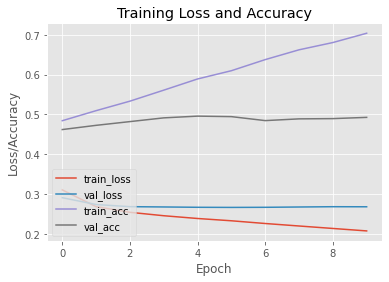

In [10]:
plot_training(history_model_1)

# Evaluate the model

In [11]:
model_1.evaluate(val_dataset)

2/2 [==============================] - 0s 174ms/step - loss: 0.2650 - accuracy: 0.4800


[0.2650398313999176, 0.47999998927116394]

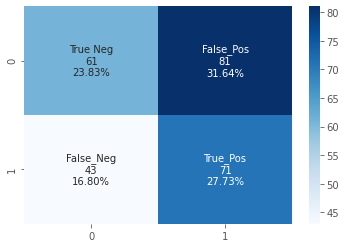

In [12]:
preds, labels = get_model_predictions(val_dataset, model_1)
plot_confusion_matrix(preds, labels)

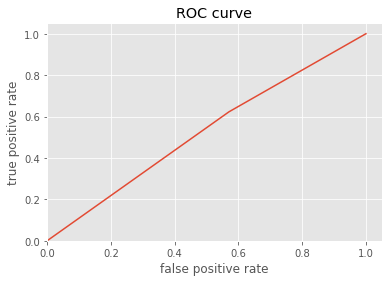

In [13]:
plot_roc_curve(preds, labels)

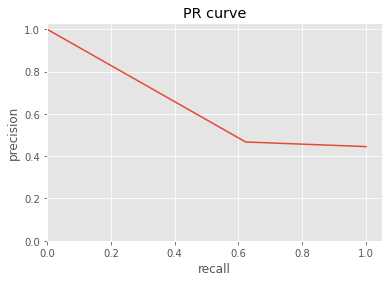

In [14]:
plot_prec_rec_curve(preds, labels)

# EfficientNetB0

In [6]:
img_width = 224
img_height = 224

In [10]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 1))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(48, activation="relu")(x)

base_model_2 = keras.models.Model(inputs, outputs)

In [11]:
base_model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 48)                61488     
Total params: 4,111,059
Trainable params: 61,488
Non-trainable params: 4,049,571
_________________________________________________________________


In [12]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_2(img_a)
feat_vect_b = base_model_2(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [13]:
#Compile the model 
model_2 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_2.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [14]:
epochs=10
history_model_2 = model_2.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 24s 517ms/step - loss: 0.4887 - accuracy: 0.5016 - val_loss: 0.4960 - val_accuracy: 0.4831
Epoch 2/10
32/32 [==============================] - 15s 457ms/step - loss: 0.4712 - accuracy: 0.5016 - val_loss: 0.4776 - val_accuracy: 0.4831
Epoch 3/10
32/32 [==============================] - 14s 455ms/step - loss: 0.4550 - accuracy: 0.5016 - val_loss: 0.4611 - val_accuracy: 0.4831
Epoch 4/10
32/32 [==============================] - 15s 456ms/step - loss: 0.4407 - accuracy: 0.5016 - val_loss: 0.4464 - val_accuracy: 0.4831
Epoch 5/10
32/32 [==============================] - 15s 457ms/step - loss: 0.4279 - accuracy: 0.5015 - val_loss: 0.4333 - val_accuracy: 0.4837
Epoch 6/10
32/32 [==============================] - 14s 456ms/step - loss: 0.4166 - accuracy: 0.5014 - val_loss: 0.4218 - val_accuracy: 0.4837
Epoch 7/10
32/32 [==============================] - 15s 456ms/step - loss: 0.4064 - accuracy: 0.5013 - val_loss: 0.4114 - val_accuracy: 0.4825